# This is an implementation of a neural network using only raw python and numpy

Coding the neural network from scratch is a by no means a good idea for real world applications. However, it is a good way to understand the inner workings of a neural network. This notebook is a good practice for deep learning.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

[0 1 2]


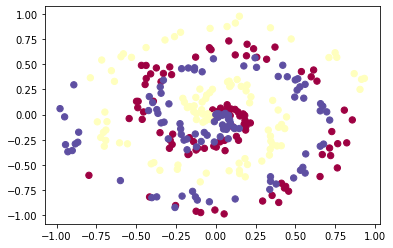

In [40]:
def create_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points) # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

# Create data with 100 points and 3 classes 
X, y = create_data(100, 3)
# print the different class names
print(np.unique(y))
# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

`create_data` is a function that generates a spiral dataset of 2D points and labels for a specified number of classes and data points per class. It creates two NumPy arrays, X and y, to hold the generated data. For each class, it generates a set of points points with a unique label. The points are generated using polar coordinates with a random offset in theta, and then converted to Cartesian coordinates. Finally, the function returns the X and y arrays as the generated dataset.

We notice that the data is not linearly separable. This is a good dataset to test our neural network on.

### Layer class

In [41]:
np.random.seed(0)

class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

* The `__init__` method takes in two parameters, `n_inputs` and `n_neurons`. `n_inputs` is the number of input neurons, and `n_neurons` is the number of neurons in this layer. In this method, the weights and biases of the layer are initialized. The weights are initialized randomly using the `np.random.randn` function. The shape of the weights matrix is `(n_inputs, n_neurons)`. The biases are initialized to zeros with a shape of `(1, n_neurons)`. The weights are initialized randomly in order to break symmetry in the network. If the weights are initialized to the same value, then the gradient descent algorithm will not be able to break symmetry and learn the correct weights. 

* The `forward` method is the implementation of the forward pass for this layer. It takes in inputs, which is a matrix of shape `(batch_size, n_inputs)`. The output of this layer is calculated by taking the dot product of inputs and weights, and then adding the biases. The output of this layer has a shape of `(batch_size, n_neurons)`. The batch size is the number of samples used in each iteration of gradient descent.

* The `backward` method in this code is responsible for computing the gradients of the loss with respect to the weights, biases, and inputs of a layer. This is an important step in the process of training a neural network using gradient descent. The `dvalues` parameter represents the derivative of the loss with respect to the output of the layer, which is passed in from the subsequent layer during backpropagation.
    1. The method first computes the gradients of the loss with respect to the weights and biases using the chain rule of calculus. The `dweights` are computed as the dot product between the transpose of the input values and the `dvalues`. This results in a matrix of the same shape as the `weights` matrix, representing the gradient of the loss with respect to each weight parameter.

    2. Similarly, the `dbiases` are computed by summing the `dvalues` along the rows (axis=0) and keeping the dimensions consistent with the `biases` matrix.
    
    3. Finally, the gradient of the loss with respect to the inputs is computed as the dot product between the `dvalues` and the transpose of the `weights`. This allows the gradient to be propagated backwards through the network to update the weights of the previous layer.

    Overall, the `backward` method is a crucial step in the backpropagation algorithm for training neural networks, and this implementation computes the gradients efficiently using matrix operations.


In summary, this class implements a dense layer in a neural network with `n_inputs` input neurons and `n_neurons` output neurons. The weights and biases are randomly initialized, and the forward pass is calculated by taking the dot product of the inputs and weights, and adding biases. The backward pass computes the gradients of the loss with respect to the weights, biases, and inputs of the layer.

In [42]:
# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0



# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


The above code defines three activation functions, ReLU, Softmax, and Sigmoid, using NumPy. Each activation function has two main methods: forward and backward.

* The `Activation_ReLU` class implements the rectified linear unit (ReLU) activation function. The `forward` method computes the element-wise maximum of the input and zero to generate the output. The `backward` method sets the gradient to zero where the input values were negative.

* The `Activation_Softmax` class implements the softmax activation function, which is commonly used for multi-class classification problems. The `forward` method computes the normalized exponential function of the input values to generate the probabilities. The `backward` method computes the Jacobian matrix of the output and multiplies it with the gradient of the loss with respect to the output.

* The `Activation_Sigmoid` class implements the sigmoid activation function. The `forward` method computes the sigmoid function of the input to generate the output. The `backward` method computes the derivative of the sigmoid function and multiplies it with the gradient of the loss with respect to the output.

In all three classes, the `forward` method saves the input values in the `self.inputs` variable, and the computed output values are saved in the `self.output` variable. In the backward method, the gradient of the loss with respect to the input values is saved in the `self.dinputs` variable.

In [43]:
# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

This code implements a Stochastic Gradient Descent (SGD) optimizer for a neural network. SGD is a common optimization algorithm used to train neural networks.

The Optimizer_SGD class contains the following methods:

* `__init__(self, learning_rate=1., decay=0., momentum=0.)`: initializes the optimizer with learning rate, decay, and momentum values. Learning rate is the step size for each update of the model parameters, decay is the rate at which the learning rate decreases over time, and momentum is the parameter that controls the influence of the previous update on the current update. The default values are 1. for learning_rate, 0. for decay, and 0. for momentum.
* `pre_update_params(self)`: adjusts the learning rate if decay is specified.
* `update_params(self, layer)`: updates the weights and biases of the specified layer using either vanilla SGD updates or momentum updates, depending on whether the momentum parameter is set.
* `post_update_params(self)`: increments the iteration count of the optimizer.

The update_params method first checks if the layer contains momentum arrays, which are arrays of zeros that are used to store the momentum of the weights and biases. If they don't exist, the arrays are initialized with zeros. The method then calculates the weight and bias updates using either vanilla SGD updates or momentum updates. The weight and bias updates are then used to update the weights and biases of the layer.

On a more general note:

Stochastic Gradient Descent (SGD) is an optimization algorithm used for minimizing the cost (loss) function in machine learning. It is a stochastic approximation of the gradient descent optimization algorithm, where instead of computing the gradient of the entire training dataset, the algorithm computes the gradient of a random sample (batch) of training data points at each iteration. This is why it is called "stochastic", as it introduces randomness into the optimization process.

SGD has been found to be very effective in practice because it converges quickly, especially for large datasets. The reason for this is that instead of waiting to compute the gradient of the entire dataset, we can use small batches of data to compute the gradient at each iteration, which leads to faster convergence.

In summary, SGD is an optimization algorithm that randomly samples training data at each iteration to compute the gradient of the cost function, and updates the model parameters in the direction of the negative gradient to minimize the cost function.

In [44]:
# Common loss class
class Loss:

    # Calculates the data loss
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

class Loss_CategoricalCrossentropy(Loss):  

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            y_pred = y_pred[range(samples), y_true]

        # Losses
        negative_log_likelihoods = -np.log(y_pred)

        # Average loss
        data_loss = np.mean(negative_log_likelihoods)

        return data_loss

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        


This code firstly defines a base class `Loss` that provides a `calculate` method to calculate the data loss between the predicted output and the ground truth labels.

The method `calculate` takes two arguments:

* `output`: the output of the model for a given batch of input data. It is a 2D numpy array of shape `(batch_size, num_classes)`.
* `y`: the ground truth labels for the input data. It is a 2D numpy array of shape `(batch_size, num_classes)`.

The `calculate` method calls the `forward` method, which is not defined in the `Loss` base class. It is implemented on the subclasses, which are the `Loss_CategoricalCrossentropy` and `Loss_BinaryCrossentropy` classes.

The `Loss_BinaryCrossentropy` is the implementation of the Binary Cross-Entropy loss function. It inherits from the base `Loss` class and overrides its `forward` and `backward` methods.

The `forward` method calculates the loss between the predicted values `y_pred` and the true values `y_true` for a binary classification task. It first clips the predicted values to avoid division by zero errors and then computes the loss as the negative logarithm of the predicted values for the positive class and the negative logarithm of one minus the predicted values for the negative class. It returns the mean loss over all the samples.

The `backward` method calculates the gradient of the loss with respect to the inputs `dvalues`. It first clips the inputs to avoid division by zero errors, then it calculates the gradient as the difference between the true values and the predicted values divided by the clipped predicted values times one minus the clipped predicted values, and then it normalizes the gradient by dividing it by the number of outputs per sample and the number of samples. The resulting gradient is stored in the `dinputs` attribute of the class.

`Loss_CategoricalCrossentropy` is a class for the categorical cross-entropy loss function, which is commonly used in multiclass classification problems. It is a subclass of the base Loss class.

The `forward` method takes in the predicted output values (`y_pred`) and the ground truth label values (`y_true`) and calculates the loss. It first checks if the ground truth labels are in one-hot format (i.e., if the shape of `y_true` is `(batch_size, num_classes)`), and if not, it extracts the probabilities corresponding to the target label for each sample. It then calculates the negative log-likelihoods of these probabilities and returns their average.

The `backward` method takes in the derivative values (`dvalues`) and the ground truth label values (`y_true`) and calculates the derivative of the loss with respect to the predicted output values. It first checks if the ground truth labels are in one-hot format and converts them if not. It then calculates the gradient using the derivative values and one-hot ground truth labels, and normalizes the gradient by dividing it by the batch size. The result is stored in the `dinputs` attribute of the class instance.



In [58]:
# Create dataset
X, y = create_data(100,2)

# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y = y.reshape(-1, 1)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense2 = Layer_Dense(64, 1)

# Create Sigmoid activation:
activation2 = Activation_Sigmoid()

# Create loss function
loss_function = Loss_BinaryCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=2, decay=1e-3)
# Train in loop
for epoch in range(10001):
    
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)

    # Calculate the data loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # Part in the brackets returns a binary mask - array consisting
    # of True/False values, multiplying it by 1 changes it into array
    # of 1s and 0s
    predictions = (activation2.output > 0.5) * 1
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, '+
              f'loss: {loss:.3f} (' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


# Validate the model

# Create test dataset
X_test, y_test = create_data(100, 2)

# Reshape labels to be a list of lists
# Inner list contains one output (either 0 or 1)
# per each output neuron, 1 in this case
y_test = y_test.reshape(-1, 1)


# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through activation function
# takes the output of second dense layer here
activation2.forward(dense2.output)

# Calculate the data loss
loss = loss_function.calculate(activation2.output, y_test)

# Calculate accuracy from output of activation2 and targets
# Part in the brackets returns a binary mask - array consisting of
# True/False values, multiplying it by 1 changes it into array
# of 1s and 0s
predictions = (activation2.output > 0.5) * 1
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

epoch: 0, acc: 0.500, loss: 0.693 (lr: 2
epoch: 100, acc: 0.620, loss: 0.658 (lr: 1.8198362147406735
epoch: 200, acc: 0.615, loss: 0.658 (lr: 1.6680567139282734
epoch: 300, acc: 0.615, loss: 0.658 (lr: 1.539645881447267
epoch: 400, acc: 0.615, loss: 0.657 (lr: 1.4295925661186561
epoch: 500, acc: 0.615, loss: 0.655 (lr: 1.33422281521014
epoch: 600, acc: 0.615, loss: 0.650 (lr: 1.2507817385866167
epoch: 700, acc: 0.605, loss: 0.639 (lr: 1.1771630370806356
epoch: 800, acc: 0.640, loss: 0.625 (lr: 1.1117287381878822
epoch: 900, acc: 0.620, loss: 0.612 (lr: 1.05318588730911
epoch: 1000, acc: 0.630, loss: 0.602 (lr: 1.0005002501250624
epoch: 1100, acc: 0.650, loss: 0.590 (lr: 0.9528346831824678
epoch: 1200, acc: 0.610, loss: 0.575 (lr: 0.9095043201455207
epoch: 1300, acc: 0.645, loss: 0.562 (lr: 0.8699434536755111
epoch: 1400, acc: 0.655, loss: 0.550 (lr: 0.8336807002917882
epoch: 1500, acc: 0.670, loss: 0.537 (lr: 0.8003201280512204
epoch: 1600, acc: 0.705, loss: 0.524 (lr: 0.76952674105425

The code is implementing a neural network with two dense layers and ReLU and sigmoid activations, using binary cross-entropy loss and stochastic gradient descent optimizer.

It first creates a training dataset with 100 samples and 2 features, and reshapes the labels to be a list of lists with one output per output neuron. It then creates the neural network layers and initializes the loss function and optimizer.

It trains the model for 10001 epochs, in each epoch performing a forward pass through the layers, calculating the loss and accuracy, and performing a backward pass to update the weights and biases using the optimizer.

Finally, it creates a test dataset, performs a forward pass on it, and calculates the accuracy and loss of the model.

The model is being trained with stochastic gradient descent and the learning rate is being reduced over time. The training is being performed for a total of 10,000 epochs.

The initial accuracy is `0.5` and the initial loss is `0.693`. The accuracy gradually increases and the loss gradually decreases over time. The learning rate is also gradually reduced over time, which is a common technique used in deep learning to ensure that the model converges to the optimal solution.

After 10,000 epochs, the validation accuracy is `0.895` and the validation loss is `0.312`. This suggests that the model has learned to generalize well to new data, since the validation accuracy is high and the validation loss is low. 

In [46]:
# now let's train and validate the neural network with the mnist dataset
# we will use the same model as before, but we will use the mnist dataset
# instead of the spiral dataset

# load the mnist dataset
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape the data
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# normalize the data
X_train = X_train / 255
X_test = X_test / 255

print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


Loaded the MNIST dataset, reshaped the images into 1D arrays, and normalized the pixel values to be between 0 and 1. The print statements at the end show the shape of the training images and labels.

The training images are of shape (60000, 784), which means there are 60,000 images in the training set, each with 784 (28x28) pixels. The training labels are of shape (60000,), which means there are 60,000 corresponding labels.

In [47]:

# create the model
dense1 = Layer_Dense(784, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 10)
activation2 = Activation_Softmax()

# create loss function
loss_function = Loss_CategoricalCrossentropy()

# create optimizer
optimizer = Optimizer_SGD()

epochs = 5

batch_size = 128

steps = int(X_train.shape[0] / batch_size)

for epoch in range(epochs):
      for step in range(steps):
            # calculate the start and end indices
            # for the current batch of data
            batch_start = step * batch_size
            batch_end = (step + 1) * batch_size
            
            # perform a forward pass of our training data through this layer
            dense1.forward(X_train[batch_start:batch_end])
            
            # perform a forward pass through activation function
            # takes the output of first dense layer here
            activation1.forward(dense1.output)
            
            # perform a forward pass through second Dense layer
            # takes outputs of activation function of first layer as inputs
            dense2.forward(activation1.output)
            
            # perform a forward pass through activation function
            # takes the output of second dense layer here
            activation2.forward(dense2.output)
            
            # calculate the data loss
            loss = loss_function.calculate(activation2.output, y_train[batch_start:batch_end])
            
            # calculate accuracy from output of activation2 and targets
            # calculate values along first axis
            predictions = np.argmax(activation2.output, axis=1)
            accuracy = np.mean(predictions==y_train[batch_start:batch_end])
            
            if not step % 100:
                print(f'epoch: {epoch}, ' +
                      f'step: {step}, ' +
                      f'acc: {accuracy:.3f}, '+
                      f'loss: {loss:.3f} (' +
                      f'lr: {optimizer.current_learning_rate})')
            
            # Backward pass
            loss_function.backward(activation2.output, y_train[batch_start:batch_end])
            activation2.backward(loss_function.dinputs)
            dense2.backward(activation2.dinputs)
            activation1.backward(dense2.dinputs)
            dense1.backward(activation1.dinputs)

            # Update weights and biases
            optimizer.pre_update_params()
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)
            optimizer.post_update_params()


# validate the model
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
loss = loss_function.calculate(activation2.output, y_test)
predictions = np.argmax(activation2.output, axis=1)
accuracy = np.mean(predictions==y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

epoch: 0, step: 0, acc: 0.086, loss: 2.302 (lr: 1.0)
epoch: 0, step: 100, acc: 0.844, loss: 0.453 (lr: 1.0)
epoch: 0, step: 200, acc: 0.906, loss: 0.250 (lr: 1.0)
epoch: 0, step: 300, acc: 0.930, loss: 0.269 (lr: 1.0)
epoch: 0, step: 400, acc: 0.906, loss: 0.235 (lr: 1.0)
epoch: 1, step: 0, acc: 0.930, loss: 0.225 (lr: 1.0)
epoch: 1, step: 100, acc: 0.938, loss: 0.157 (lr: 1.0)
epoch: 1, step: 200, acc: 0.961, loss: 0.144 (lr: 1.0)
epoch: 1, step: 300, acc: 0.961, loss: 0.167 (lr: 1.0)
epoch: 1, step: 400, acc: 0.922, loss: 0.231 (lr: 1.0)
epoch: 2, step: 0, acc: 0.969, loss: 0.110 (lr: 1.0)
epoch: 2, step: 100, acc: 0.977, loss: 0.098 (lr: 1.0)
epoch: 2, step: 200, acc: 0.945, loss: 0.124 (lr: 1.0)
epoch: 2, step: 300, acc: 0.969, loss: 0.134 (lr: 1.0)
epoch: 2, step: 400, acc: 0.945, loss: 0.174 (lr: 1.0)
epoch: 3, step: 0, acc: 0.977, loss: 0.099 (lr: 1.0)
epoch: 3, step: 100, acc: 0.961, loss: 0.090 (lr: 1.0)
epoch: 3, step: 200, acc: 0.953, loss: 0.117 (lr: 1.0)
epoch: 3, step: 30

This code trains and validates a neural network using the MNIST dataset. The neural network is created with two dense layers, using the ReLU activation function on the first layer and the Softmax activation function on the second layer. The loss function used is categorical cross-entropy, and the optimizer used is stochastic gradient descent (SGD).

The training is performed for a specified number of epochs, where each epoch consists of iterating over the entire dataset in batches. For each batch, a forward pass is performed through the neural network, the loss is calculated, and the gradients are propagated backward through the network using backpropagation. The optimizer is then used to update the weights and biases of the network. During training, the accuracy and loss are printed every 100 steps.

After training, the model is validated using the test set. The same forward pass procedure is performed, and the accuracy and loss are calculated and printed.

In the first epoch, the accuracy increased rapidly from 0.086 to 0.930, and the loss decreased from 2.302 to 0.269. This suggests that the model quickly learned to fit the training data. In the subsequent epochs, the accuracy continued to improve gradually, while the loss decreased more slowly.

At the end of the fifth epoch, the model achieved an accuracy of 0.953 on the training data. However, the accuracy on the validation data was higher at 0.963, which suggests that the model did not overfit too much to the training data. The validation loss was also relatively low at 0.131. 


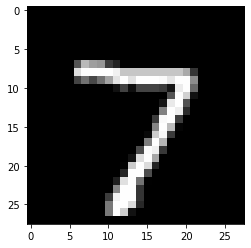

prediction: 7


In [49]:
# get the image and its prediction
image = X_test[0]
prediction = activation2.output[0]

# show the image and prediction
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.show()
print(f'prediction: {np.argmax(prediction)}')

As we can see the prediction is correct. The model correctly predicted that the image is a 7.

In conclusion, the process of creating a neural network from scratch can be challenging and time-consuming, but it can also be incredibly rewarding. Through this project, I gained a deeper understanding of how neural networks work and the various components that make them up.

Creating a neural network from scratch allowed me to have complete control over every aspect of the model, from the input layer to the output layer. This gave me the freedom to experiment with different architectures and hyperparameters, ultimately leading to a better understanding of how they affect the performance of the model.

While it is important to understand the basics of neural networks, creating a fully functioning model from scratch requires a deep understanding of linear algebra, calculus, and programming. It is essential to have a solid foundation in these subjects before attempting to create a neural network from scratch.

In conclusion, creating a neural network from scratch is a challenging but rewarding process that can deepen your understanding of neural networks and enhance your skills in linear algebra, calculus, and programming.